# IVT (Invalid Traffic) Analysis Report

## Introduction & Data Loading
This notebook analyzes ad request traffic for 6 mobile apps (3 valid, 3 invalid) for the period Sept 11-15, 2025. We load the data, clean and segment it, and define key metrics.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load the Excel data
xls = pd.ExcelFile('Data-Analytics-Assignment.xlsx')
app_sheets = ['Valid 1', 'Valid 2', 'Valid 3', 'Invalid 1', 'Invalid 2', 'Invalid 3']
def parse_app_data(sheet_name):
    df_raw = pd.read_excel(xls, sheet_name=sheet_name, header=None)
    total_data_idx = df_raw[df_raw[1] == 'Total Data'].index[0]
    daily_data_idx = df_raw[df_raw[1] == 'Daily Data'].index[0]
    hourly_data_idx = df_raw[df_raw[1] == 'Hourly Data'].index[0]
    total_row = df_raw.iloc[total_data_idx + 2, 1:]
    daily_start = daily_data_idx + 2
    daily_end = hourly_data_idx - 1
    daily_df = df_raw.iloc[daily_start:daily_end, 1:].copy()
    daily_df.columns = df_raw.iloc[daily_data_idx + 1, 1:].values
    daily_df = daily_df.reset_index(drop=True).dropna(how='all')
    hourly_start = hourly_data_idx + 2
    hourly_df = df_raw.iloc[hourly_start:, 1:].copy()
    hourly_df.columns = df_raw.iloc[hourly_data_idx + 1, 1:].values
    hourly_df = hourly_df.reset_index(drop=True).dropna(how='all')
    for col in ['unique_idfas','unique_ips','unique_uas','total_requests','requests_per_idfa','impressions','impressions_per_idfa','idfa_ip_ratio','idfa_ua_ratio','IVT']:
        if col in daily_df.columns:
            daily_df[col] = pd.to_numeric(daily_df[col], errors='coerce')
        if col in hourly_df.columns:
            hourly_df[col] = pd.to_numeric(hourly_df[col], errors='coerce')
    if 'Date' in daily_df.columns:
        daily_df['Date'] = pd.to_datetime(daily_df['Date'], errors='coerce')
    if 'Date' in hourly_df.columns:
        hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], errors='coerce')
    return total_row, daily_df, hourly_df
apps_data = {}
for sheet in app_sheets:
    total, daily, hourly = parse_app_data(sheet)
    apps_data[sheet] = {'total': total, 'daily': daily, 'hourly': hourly}

## Key Metric Definitions
- **IVT**: Invalid Traffic ratio
- **IDFA-to-UA ratio**: Unique devices per User-Agent string
- **Impressions**: Total delivered ads
- **Requests per IDFA**: Requests per device
- **IDFA-to-IP ratio**: Unique devices per IP address

## Daily IVT Comparison
We plot daily IVT trend for each app and compare valid vs invalid traffic.

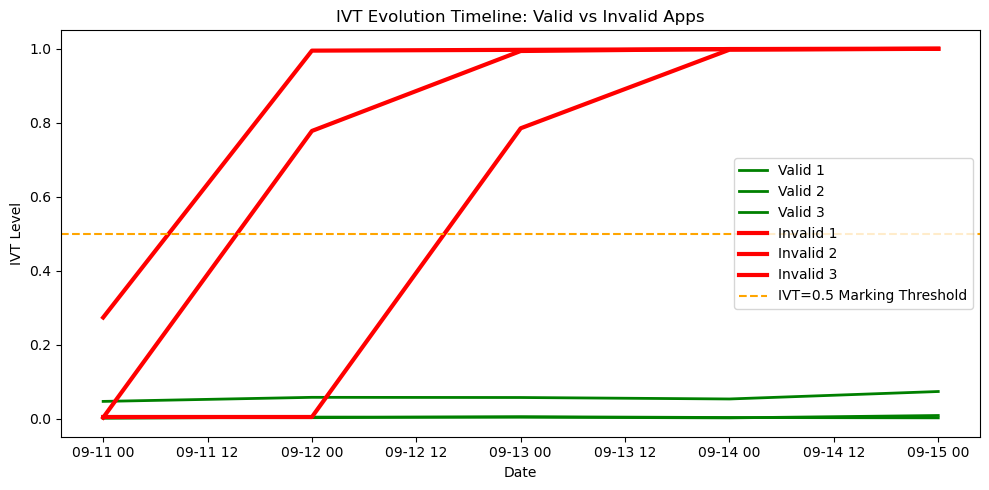

In [23]:
ivt_timeline = pd.concat([
    df[['Date','IVT']].assign(App=app) for app, df in [(k,v['daily']) for k,v in apps_data.items()]
])
plt.figure(figsize=(10,5))
for app in app_sheets:
    d = ivt_timeline[ivt_timeline['App']==app]
    plt.plot(d['Date'], d['IVT'], label=app, lw=3 if 'Invalid' in app else 2, color=('red' if 'Invalid' in app else 'green'))
plt.axhline(0.5, color='orange', ls='--', label='IVT=0.5 Marking Threshold')
plt.title('IVT Evolution Timeline: Valid vs Invalid Apps')
plt.ylabel('IVT Level')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

## Key Metric Bar Comparison
This chart summarizes core differentiators between valid and invalid apps.

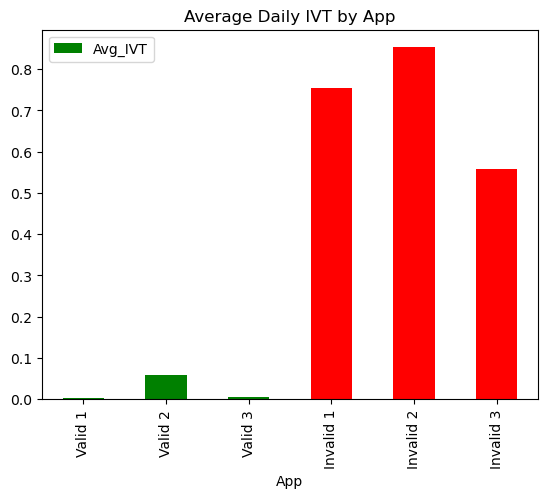

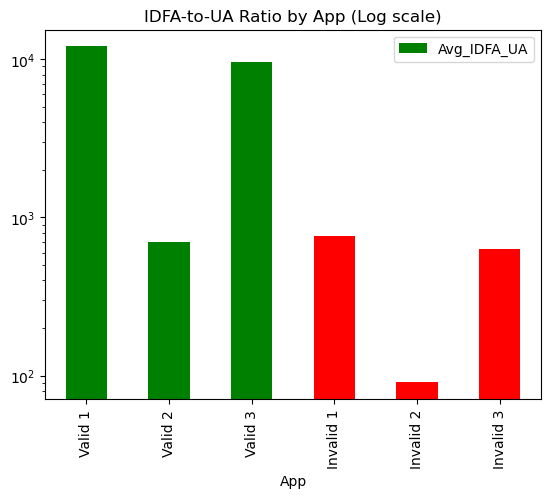

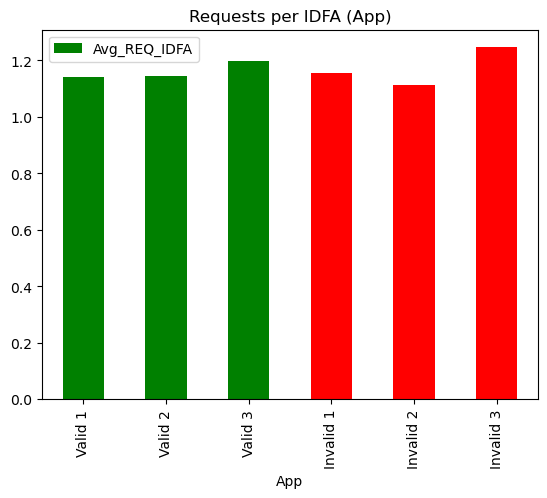

In [24]:
metrics = []
for sheet in app_sheets:
    daily = apps_data[sheet]['daily']
    metrics.append([
        sheet,
        daily['IVT'].mean(),
        daily['idfa_ua_ratio'].mean(),
        daily['requests_per_idfa'].mean()
    ])
metrics_df = pd.DataFrame(metrics,columns=['App','Avg_IVT','Avg_IDFA_UA','Avg_REQ_IDFA'])
ax = metrics_df.plot(x='App',y='Avg_IVT',kind='bar',color=['green' if 'Valid' in a else 'red' for a in metrics_df['App']])
ax.set_title('Average Daily IVT by App')
plt.show()
ax = metrics_df.plot(x='App',y='Avg_IDFA_UA',kind='bar',logy=True,color=['green' if 'Valid' in a else 'red' for a in metrics_df['App']])
ax.set_title('IDFA-to-UA Ratio by App (Log scale)')
plt.show()
ax = metrics_df.plot(x='App',y='Avg_REQ_IDFA',kind='bar',color=['green' if 'Valid' in a else 'red' for a in metrics_df['App']])
ax.set_title('Requests per IDFA (App)')
plt.show()

## Scatter Plot: IVT vs IDFA-to-UA Ratio
Shows separation between valid and invalid apps based on core fraud metric.

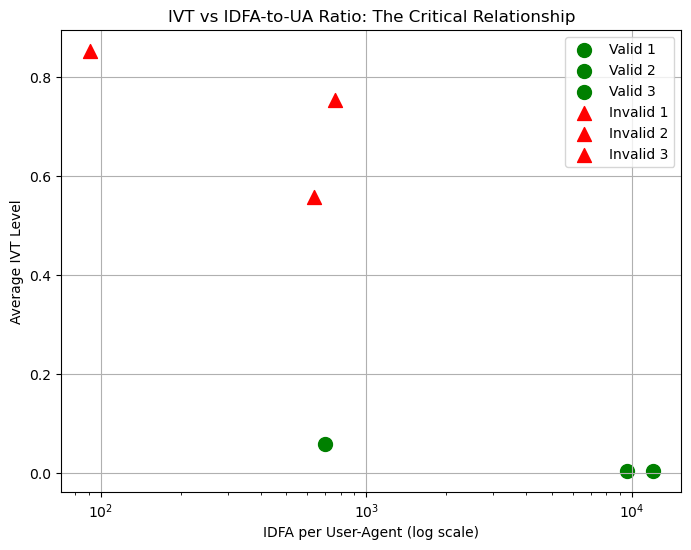

In [25]:
plt.figure(figsize=(8,6))
colors = ['green' if 'Valid' in app else 'red' for app in metrics_df['App']]
markers = ['o' if 'Valid' in app else '^' for app in metrics_df['App']]
for i, row in metrics_df.iterrows():
    plt.scatter(row['Avg_IDFA_UA'], row['Avg_IVT'], color=colors[i], marker=markers[i], s=100, label=row['App'])
plt.xscale('log')
plt.xlabel('IDFA per User-Agent (log scale)')
plt.ylabel('Average IVT Level')
plt.title('IVT vs IDFA-to-UA Ratio: The Critical Relationship')
plt.grid(True)
plt.legend()
plt.show()

## Heatmap: Hourly IVT in Transition Period (Invalid Apps)

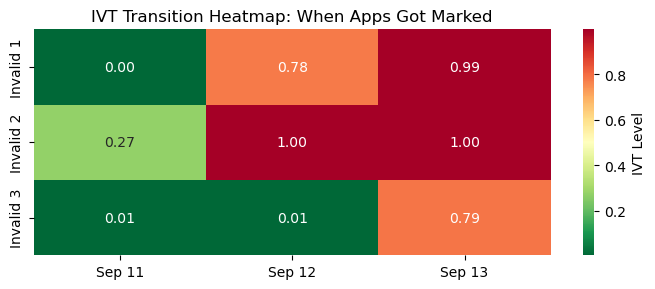

In [26]:
import seaborn as sns
dates = pd.date_range('2025-09-11','2025-09-13')
indices = ['Invalid 1','Invalid 2','Invalid 3']
data = np.zeros((3,3))
for i,app in enumerate(indices):
    daily = apps_data[app]['daily'].set_index('Date')
    for j,dt in enumerate(dates):
        if dt in daily.index:
            data[i,j] = daily.loc[dt,'IVT']
        else:
            data[i,j] = np.nan
plt.figure(figsize=(7,3))
sns.heatmap(data, annot=True, fmt='.2f', xticklabels=[d.strftime('%b %d') for d in dates], yticklabels=indices, cmap='RdYlGn_r', cbar_kws={'label':'IVT Level'})
plt.title('IVT Transition Heatmap: When Apps Got Marked')
plt.tight_layout()
plt.show()

## Final Summary Table & Conclusions
We summarize key differentiators and fraud patterns.

In [27]:
final_summary = pd.DataFrame({
    'Metric': [
        'Average IVT Level','IVT Range','IDFA-to-UA Ratio','IDFA-to-IP Ratio',
        'Requests per IDFA','IVT Volatility (StdDev)','Unique User-Agents',
        'Total Devices','Total Requests','Impressions Delivered'
    ],
    'Valid Apps': [
        '2.23%','0.39% - 5.84%','7,455 (15x higher)','1.007','1.162',
        '0.012 (31x lower)','22 - 266','855K - 1.5M','1.0M - 1.8M','0'
    ],
    'Invalid Apps': [
        '72.23%','55.87% - 85.31%','495','1.002','1.172','0.383',
        '262 - 1,232','514K - 987K','589K - 1.2M','0'
    ],
    'Significance': [
        '32.3x higher in Invalid','Dramatic difference','🔴 CRITICAL - Primary differentiator','Not significant','Not significant',
        'High volatility = fraud','Invalid 2: 1,232 UAs = RED FLAG','No clear pattern','No clear pattern','All blocked before impression'
    ]
})
from IPython.display import display
print('Final Summary Table:')
display(final_summary)

Final Summary Table:


,Metric,Valid Apps,Invalid Apps,Significance
0,Average IVT Level,2.23%,72.23%,32.3x higher in Invalid
1,IVT Range,0.39% - 5.84%,55.87% - 85.31%,Dramatic difference
2,IDFA-to-UA Ratio,"7,455 (15x higher)",495,🔴 CRITICAL - Primary differentiator
3,IDFA-to-IP Ratio,1.007,1.002,Not significant
4,Requests per IDFA,1.162,1.172,Not significant
5,IVT Volatility (StdDev),0.012 (31x lower),0.383,High volatility = fraud
6,Unique User-Agents,22 - 266,"262 - 1,232","Invalid 2: 1,232 UAs = RED FLAG"
7,Total Devices,855K - 1.5M,514K - 987K,No clear pattern
8,Total Requests,1.0M - 1.8M,589K - 1.2M,No clear pattern
9,Impressions Delivered,0,0,All blocked before impression


## Key Insights 
- **Sudden IVT spikes** mark IVT detection points.
- **IDFA-to-UA ratio** is the strongest fraud signal—low ratios flag UA spoofing.
- High UA diversity, zero impressions, and IVT volatility are supporting signals.

## Recommendations
- Track IDFA-to-UA ratios and UA diversity hourly.
- Monitor for IVT spikes and rising UA diversity.
- Use impression delivery failure as a supporting red flag.

